In [1]:
import os
from tools import config

if not os.path.exists(config.DEFECTS_PATH):
    !python "tools/extracted_defetcs.py"

In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import cv2

In [3]:
datagenAug = ImageDataGenerator(
    rotation_range=90,
	zoom_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	validation_split=0.2
)

In [4]:
trainGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="training")

testGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="validation")

Found 8012 images belonging to 6 classes.
Found 2001 images belonging to 6 classes.


In [30]:
resnet_model = InceptionV3(weights='imagenet', include_top=False,  input_tensor=Input(shape=(224, 224, 3)))

for layer in resnet_model.layers[:-1]:
    layer.trainable = False

head = resnet_model.output
head = GlobalAveragePooling2D()(head)
fc = Dense(1024, activation = "relu")(head)
fc = Dropout(0.2)(fc)
output = Dense(len(trainGen.class_indices), activation = "softmax")(fc)

model = Model(inputs=resnet_model.input, outputs=output)

In [31]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [32]:
checkpoint = ModelCheckpoint(os.path.sep.join([config.OUTPUT_PATH, "inceptionV3.h5"]), monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [33]:
hist = model.fit(
    trainGen, steps_per_epoch=trainGen.samples // 32,
	validation_data=testGen, validation_steps=testGen.samples // 32,
	epochs=15, callbacks=[checkpoint, early])

model.save(os.path.sep.join([config.OUTPUT_PATH, "inceptionV3.model"]), save_format='h5')

Epoch 1/15

Epoch 1: accuracy improved from -inf to 0.15625, saving model to output\inceptionV3.h5
  1/250 [..............................] - ETA: 15:56 - loss: 33.3503 - accuracy: 0.1562
Epoch 1: accuracy improved from 0.15625 to 0.21875, saving model to output\inceptionV3.h5
  2/250 [..............................] - ETA: 2:37 - loss: 28.0835 - accuracy: 0.2188 
Epoch 1: accuracy did not improve from 0.21875
  3/250 [..............................] - ETA: 1:27 - loss: 29.5696 - accuracy: 0.1771
Epoch 1: accuracy did not improve from 0.21875
  4/250 [..............................] - ETA: 1:22 - loss: 26.1665 - accuracy: 0.1953
Epoch 1: accuracy did not improve from 0.21875
  5/250 [..............................] - ETA: 1:19 - loss: 25.1650 - accuracy: 0.2062
Epoch 1: accuracy did not improve from 0.21875
  6/250 [..............................] - ETA: 1:17 - loss: 24.8630 - accuracy: 0.2083
Epoch 1: accuracy did not improve from 0.21875
  7/250 [..............................] - ETA

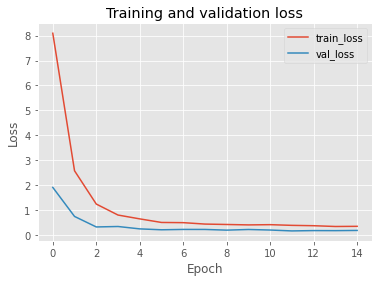

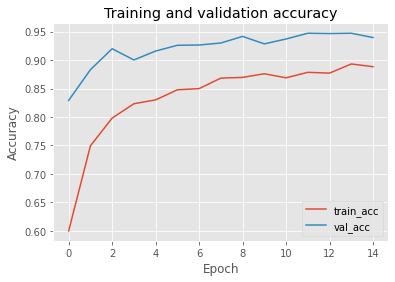

In [34]:
N = np.arange(0, 15)
plt.style.use("ggplot")

plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "inception_losses.png"]))

plt.figure()
plt.plot(N, hist.history["accuracy"], label="train_acc")
plt.plot(N, hist.history["val_accuracy"], label="val_acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "inception_accuracy.png"]))

plt.show()

In [5]:
from tensorflow.keras.models import load_model
model = load_model(os.path.sep.join([config.OUTPUT_PATH, "inceptionV3.model"]))

              precision    recall  f1-score   support

        open      0.934     0.835     0.882       388
       short      0.690     0.904     0.783       301
    mousebit      0.906     0.687     0.781       393
        spur      0.638     0.895     0.745       325
      copper      0.957     0.905     0.930       294
    pin-hole      0.974     0.740     0.841       300

    accuracy                          0.822      2001
   macro avg      0.850     0.828     0.827      2001
weighted avg      0.853     0.822     0.826      2001



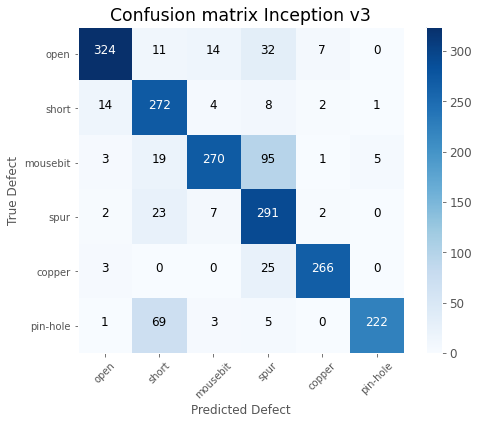

In [7]:
import itertools

predictions = list()
for path in testGen.filepaths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    predictions.append(preds.argmax(axis=1))

print(classification_report(testGen.classes,
	predictions, target_names=testGen.class_indices, digits=3))

plt.style.use("ggplot")
plt.grid(False)
plt.rcParams["figure.figsize"] = (8,6)
font = {'size' : 12}
plt.rc('font', **font)

cm = confusion_matrix(testGen.classes, predictions)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))

plt.xticks(tick_marks, testGen.class_indices, rotation=45)
plt.yticks(tick_marks, testGen.class_indices)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Defect')
plt.ylabel('True Defect')
plt.title('Confusion matrix Inception v3')
plt.savefig('output/inception_confusion_matrix.png')
plt.show()